# Harmony benchmarking
Comparison of results obtained using R and Python implementations

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import scanpy as sc

from scipy.stats import ttest_ind
from tqdm.notebook import tqdm

sc.set_figure_params(dpi=150)

JUPYTER_DIR = os.path.dirname(os.path.abspath("__file__"))
SYMPHONY_DIR = os.path.dirname(JUPYTER_DIR)
DATA_DIR = os.path.join(os.path.dirname(JUPYTER_DIR), "data")

sys.path.append(SYMPHONY_DIR)
sys.path

import symphonypy as sp

In [2]:
%load_ext rpy2.ipython
import rpy2
rpy2.rinterface_lib.callbacks.consolewrite_warnerror = lambda x: print(x, end="")

In [3]:
adata = sc.read_h5ad(os.path.join(DATA_DIR, "PBMC_Satija.h5ad"))
adata.layers["counts"] = adata.X.copy()

In [4]:
# Preprocessing

n_comps = 30
max_value = 10
n_neighbors = 21

adata.var_names_make_unique()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key="donor")
adata.raw = adata
sc.pp.scale(adata, max_value=max_value)
adata.X[adata.X < -10] = -10
sc.tl.pca(adata, n_comps=n_comps, zero_center=False)

/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


/home/ku/mambaforge/envs/symphony/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


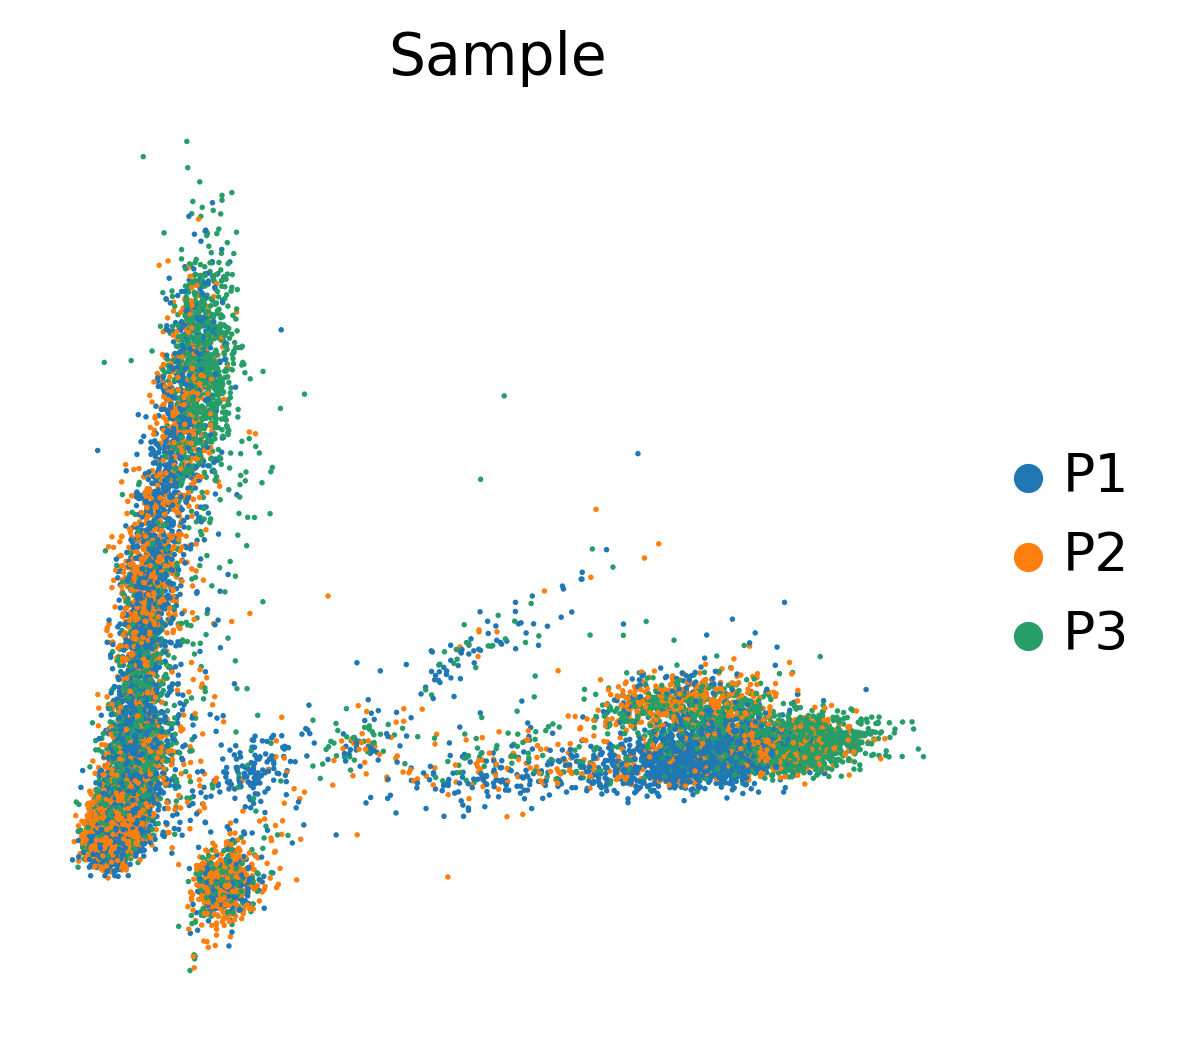

In [5]:
sc.pl.pca(adata, color="donor", frameon=False, title="Sample")

In [6]:
my_pca_embeddings = adata.obsm["X_pca"].copy()
meta_data = adata.obs.copy()

In [7]:
random_seed = 1

## Harmony

**Harmonypy defaults:**  
    theta = 1,  
    lamb = 1,  
    sigma = 0.1,   
    nclust = min(round(N / 30.0), 100),  
    tau = 0,  
    block_size = 0.05,   
    max_iter_kmeans = 20,  
    epsilon_cluster = 1e-5,  
    epsilon_harmony = 1e-4,   
    
**Harmony R defaults:**  
    theta = 2,  
    lambda = 1,  
    sigma = 0.1,  
    nclust = min(round(N / 30), 100),  
    tau = 0,  
    block.size = 0.05,  
    max.iter.harmony = 10,  
    max.iter.cluster = 20,  
    epsilon.cluster = 1e-5,  
    epsilon.harmony = 1e-4,  

In [8]:
common_kwargs = {
    "theta": 2,
    "sigma": 0.1,
    "nclust": 100,
    "tau": 0
}

R_kwargs = {
    "lambda": 1,
    "block.size": 0.05,
    "max.iter.cluster": 20,
    "epsilon.cluster": 1e-5,
    "epsilon.harmony": 1e-4
}

py_kwargs = {
    "lamb": 1,
    "block_size": 0.05, 
    "max_iter_kmeans": 20,
    "epsilon_cluster": 1e-5,
    "epsilon_harmony": 1e-4, 
}

### Harmony R

In [9]:
R_kwargs["max.iter.harmony"] = 20

sp._utils._harmony_integrate_R(
    adata,
    key="donor",
    ref_basis_adjusted="X_pca_harmony_R",
    random_seed=random_seed,
    verbose=True,
    **common_kwargs,
    **R_kwargs
)

Harmony 1/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 2/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 3/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 4/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 5/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Harmony 6/20
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
********************

### Harmonypy

In [10]:
import harmonypy
ho = harmonypy.run_harmony(
    my_pca_embeddings, 
    meta_data,
    "donor",
    max_iter_harmony=20,
    random_state=random_seed,
    **common_kwargs,
    **py_kwargs
)

2023-01-08 01:12:11,520 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-01-08 01:12:15,276 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-01-08 01:12:15,634 - harmonypy - INFO - Iteration 1 of 20
2023-01-08 01:12:32,592 - harmonypy - INFO - Iteration 2 of 20
2023-01-08 01:12:39,088 - harmonypy - INFO - Iteration 3 of 20
2023-01-08 01:12:45,378 - harmonypy - INFO - Iteration 4 of 20
2023-01-08 01:12:50,742 - harmonypy - INFO - Iteration 5 of 20
2023-01-08 01:12:57,596 - harmonypy - INFO - Iteration 6 of 20
2023-01-08 01:13:02,699 - harmonypy - INFO - Iteration 7 of 20
2023-01-08 01:13:09,764 - harmonypy - INFO - Iteration 8 of 20
2023-01-08 01:13:13,193 - harmonypy - INFO - Iteration 9 of 20
2023-01-08 01:13:15,292 - harmonypy - INFO - Iteration 10 of 20
2023-01-08 01:13:21,446 - harmonypy - INFO - Iteration 11 of 20
2023-01-08 01:13:27,337 - harmonypy - INFO - Iteration 12 of 20
2023-01-08 01:13:29,158 - harmonypy - INFO - Converged after

In [11]:
adata.obsm["X_pca_harmony_Python"] = ho.Z_corr.copy().T

### Harmony R vs Harmonypy

In [12]:
# Compute neighbors
sc.pp.neighbors(adata, use_rep="X_pca_harmony_R", key_added="Harmony_R", n_neighbors=n_neighbors)
sc.pp.neighbors(adata, use_rep="X_pca_harmony_Python", key_added="Harmony_Python", n_neighbors=n_neighbors)

In [13]:
# Compare number of same neighbors for each cell
def compare_neighbors(adata, obsp1, obsp2):
    return ((adata.obsp[obsp1] > 0).multiply((adata.obsp[obsp2]) > 0)).sum(axis=1)

In [14]:
n_same = compare_neighbors(adata, "Harmony_R_distances", "Harmony_Python_distances")

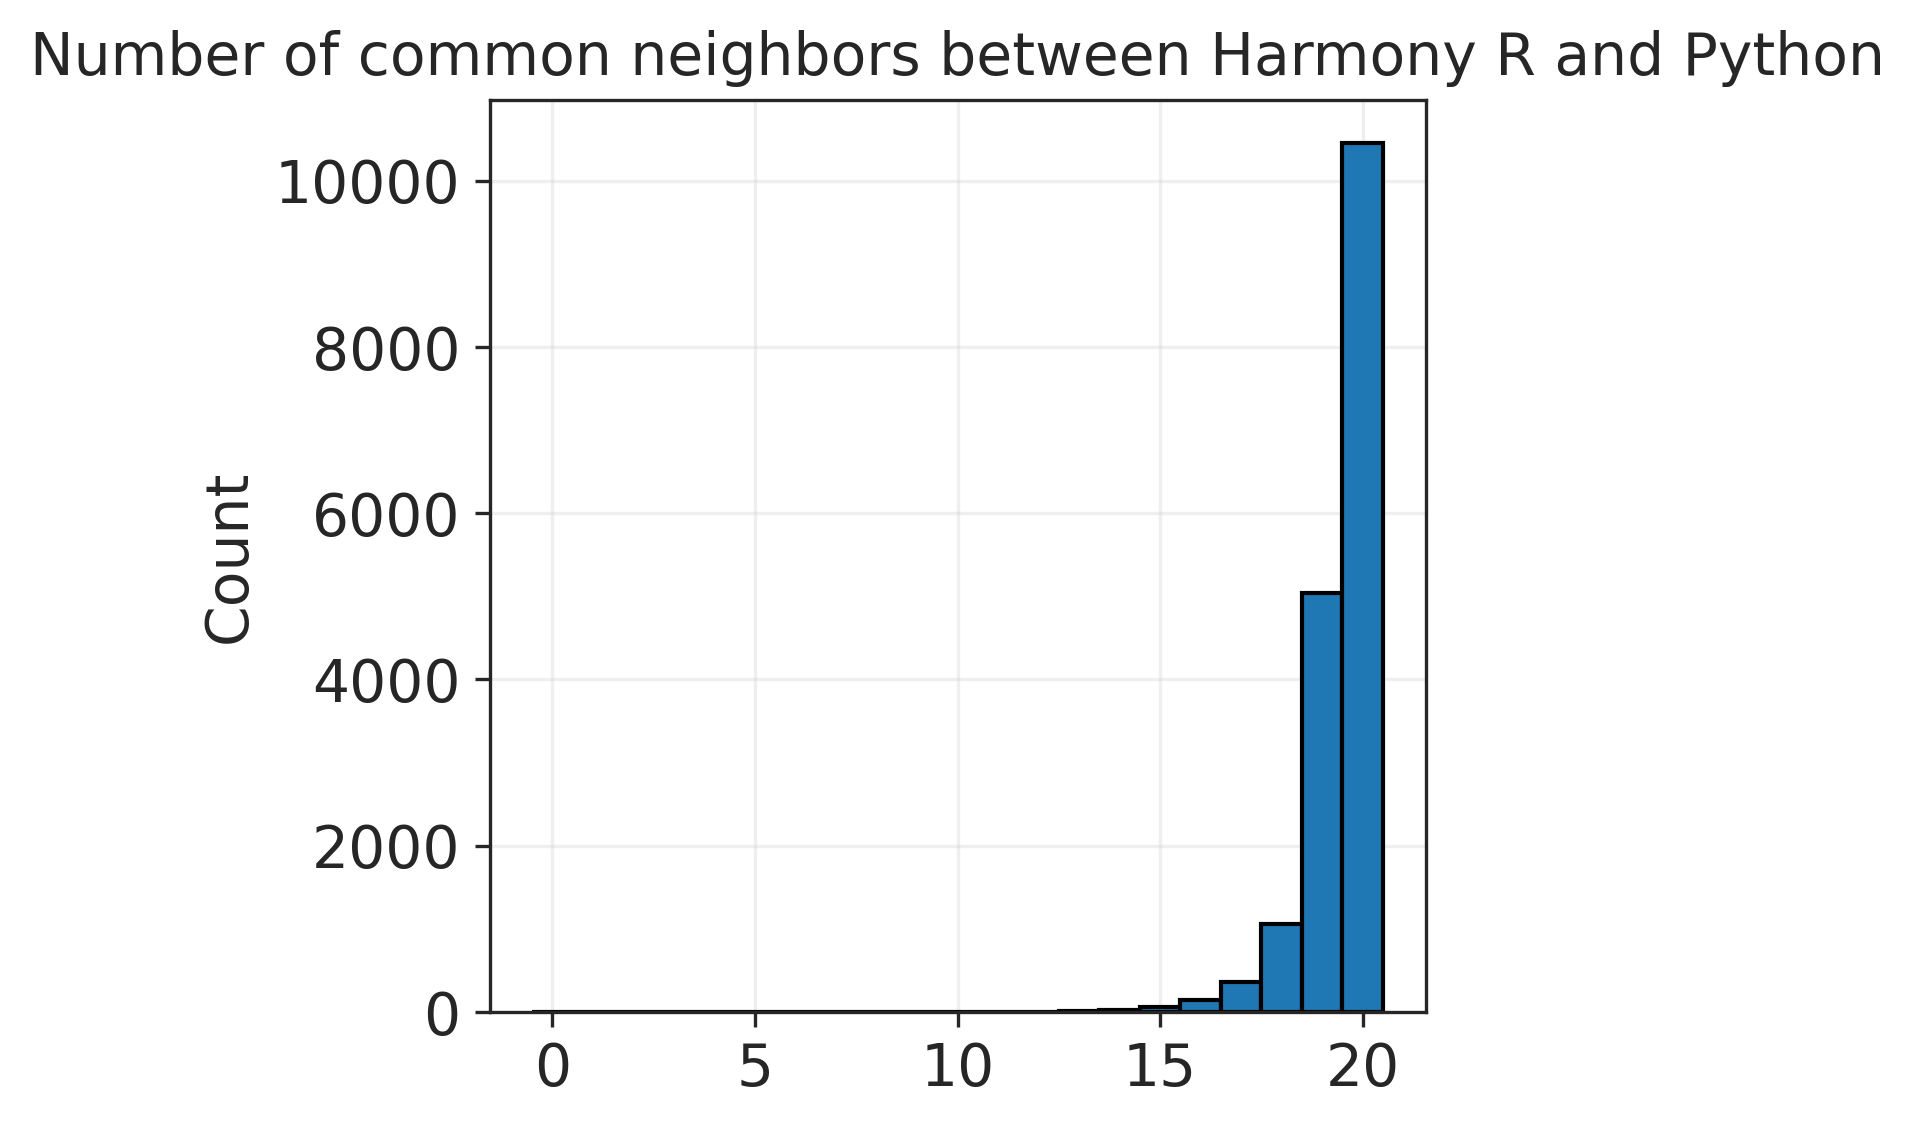

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(4, 4))
sns.histplot(n_same, ax=ax, discrete=True, linewidth=1, edgecolor="black", alpha=1, legend=False)
ax.set_title("Number of common neighbors between Harmony R and Python")
ax.grid(alpha=0.3)

### Random restarts
- count once Harmony R to use as a reference  
- restart Harmony R and harmonypy n_restarts times with different random states  
- count average of common neighbors between Harmony R results and the reference,  
  and between harmonypy results and the reference  
- compare average distributions (t-test)

In [23]:
import logging
logging.basicConfig(level=logging.INFO,
                    force = True)
logger = logging.getLogger()
logger.info("oou")

INFO:root:oou


In [24]:
def compare_harmony(
    lang,
    adata,
    my_pca_embeddings,
    random_seed,
    key,
    reference_neighbors,
    max_iter_harmony=20,
    verbose=False,
    **kwargs
):
    
    if lang == "py":
        ho = harmonypy.run_harmony(
            my_pca_embeddings, 
            meta_data,
            key,
            max_iter_harmony=max_iter_harmony,
            random_state=random_seed,
            verbose=verbose,
            **kwargs
        )
        converged = ho.check_convergence(1)
        adata.obsm["X_pca_harmony_Python"] = ho.Z_corr.copy().T
        use_rep = "X_pca_harmony_Python"
        key_added="Harmony_Python"
            
    elif lang == "R":
            kwargs["max.iter.harmony"] = max_iter_harmony

            sp._utils._harmony_integrate_R(
                adata,
                key,
                adjusted_basis="X_pca_harmony",
                random_seed=random_seed,
                verbose=verbose,
                **kwargs,
            )
            converged = adata.uns["harmony"]["converged"]
            use_rep = "X_pca_harmony"
            key_added="Harmony_R_restart"
    else:
        raise Exception(f"Unrealized language '{lang}' :)")

    if not converged:
        logger.warning(f"Not converged, lang: {lang}, max iterations: {max_iter_harmony}, random seed: {random_seed}")
    
    sc.pp.neighbors(adata, use_rep=use_rep, key_added=key_added, n_neighbors=n_neighbors)
    n_same = compare_neighbors(adata, reference_neighbors, f"{key_added}_distances")
    
    return n_same.mean()

In [25]:
n_restarts = 30

In [28]:
harmonypy_level = logging.getLogger('harmonypy').level
logging.getLogger('harmonypy').setLevel(logging.WARNING)

logger.warning("check")

average_R = np.zeros(n_restarts)
average_py = np.zeros(n_restarts)

for i in tqdm(range(n_restarts)):
    
    random_seed_i = random_seed + i + 1  # random_seed=random_seed was used for Harmony_R_distances
    
    average_R[i] = compare_harmony(
        "R", adata, my_pca_embeddings, random_seed_i, "donor", "Harmony_R_distances", **common_kwargs, **R_kwargs,
    )
    
    average_py[i] = compare_harmony(
        "py", adata, my_pca_embeddings, random_seed_i, "donor", "Harmony_R_distances", **common_kwargs, **py_kwargs,
    )
    
logging.getLogger('harmonypy').setLevel(harmonypy_level)

  0%|          | 0/30 [00:00<?, ?it/s]

In [31]:
ttest_ind(average_R, average_py)

Ttest_indResult(statistic=-1.266084879757682, pvalue=0.21054442967693957)

In [ ]:
average_df = pd.DataFrame(
    {
        "average": np.concatenate([average_R, average_py]),
        "implementation": ["R"] * n_restarts + ["Python"] * n_restarts
    }
)

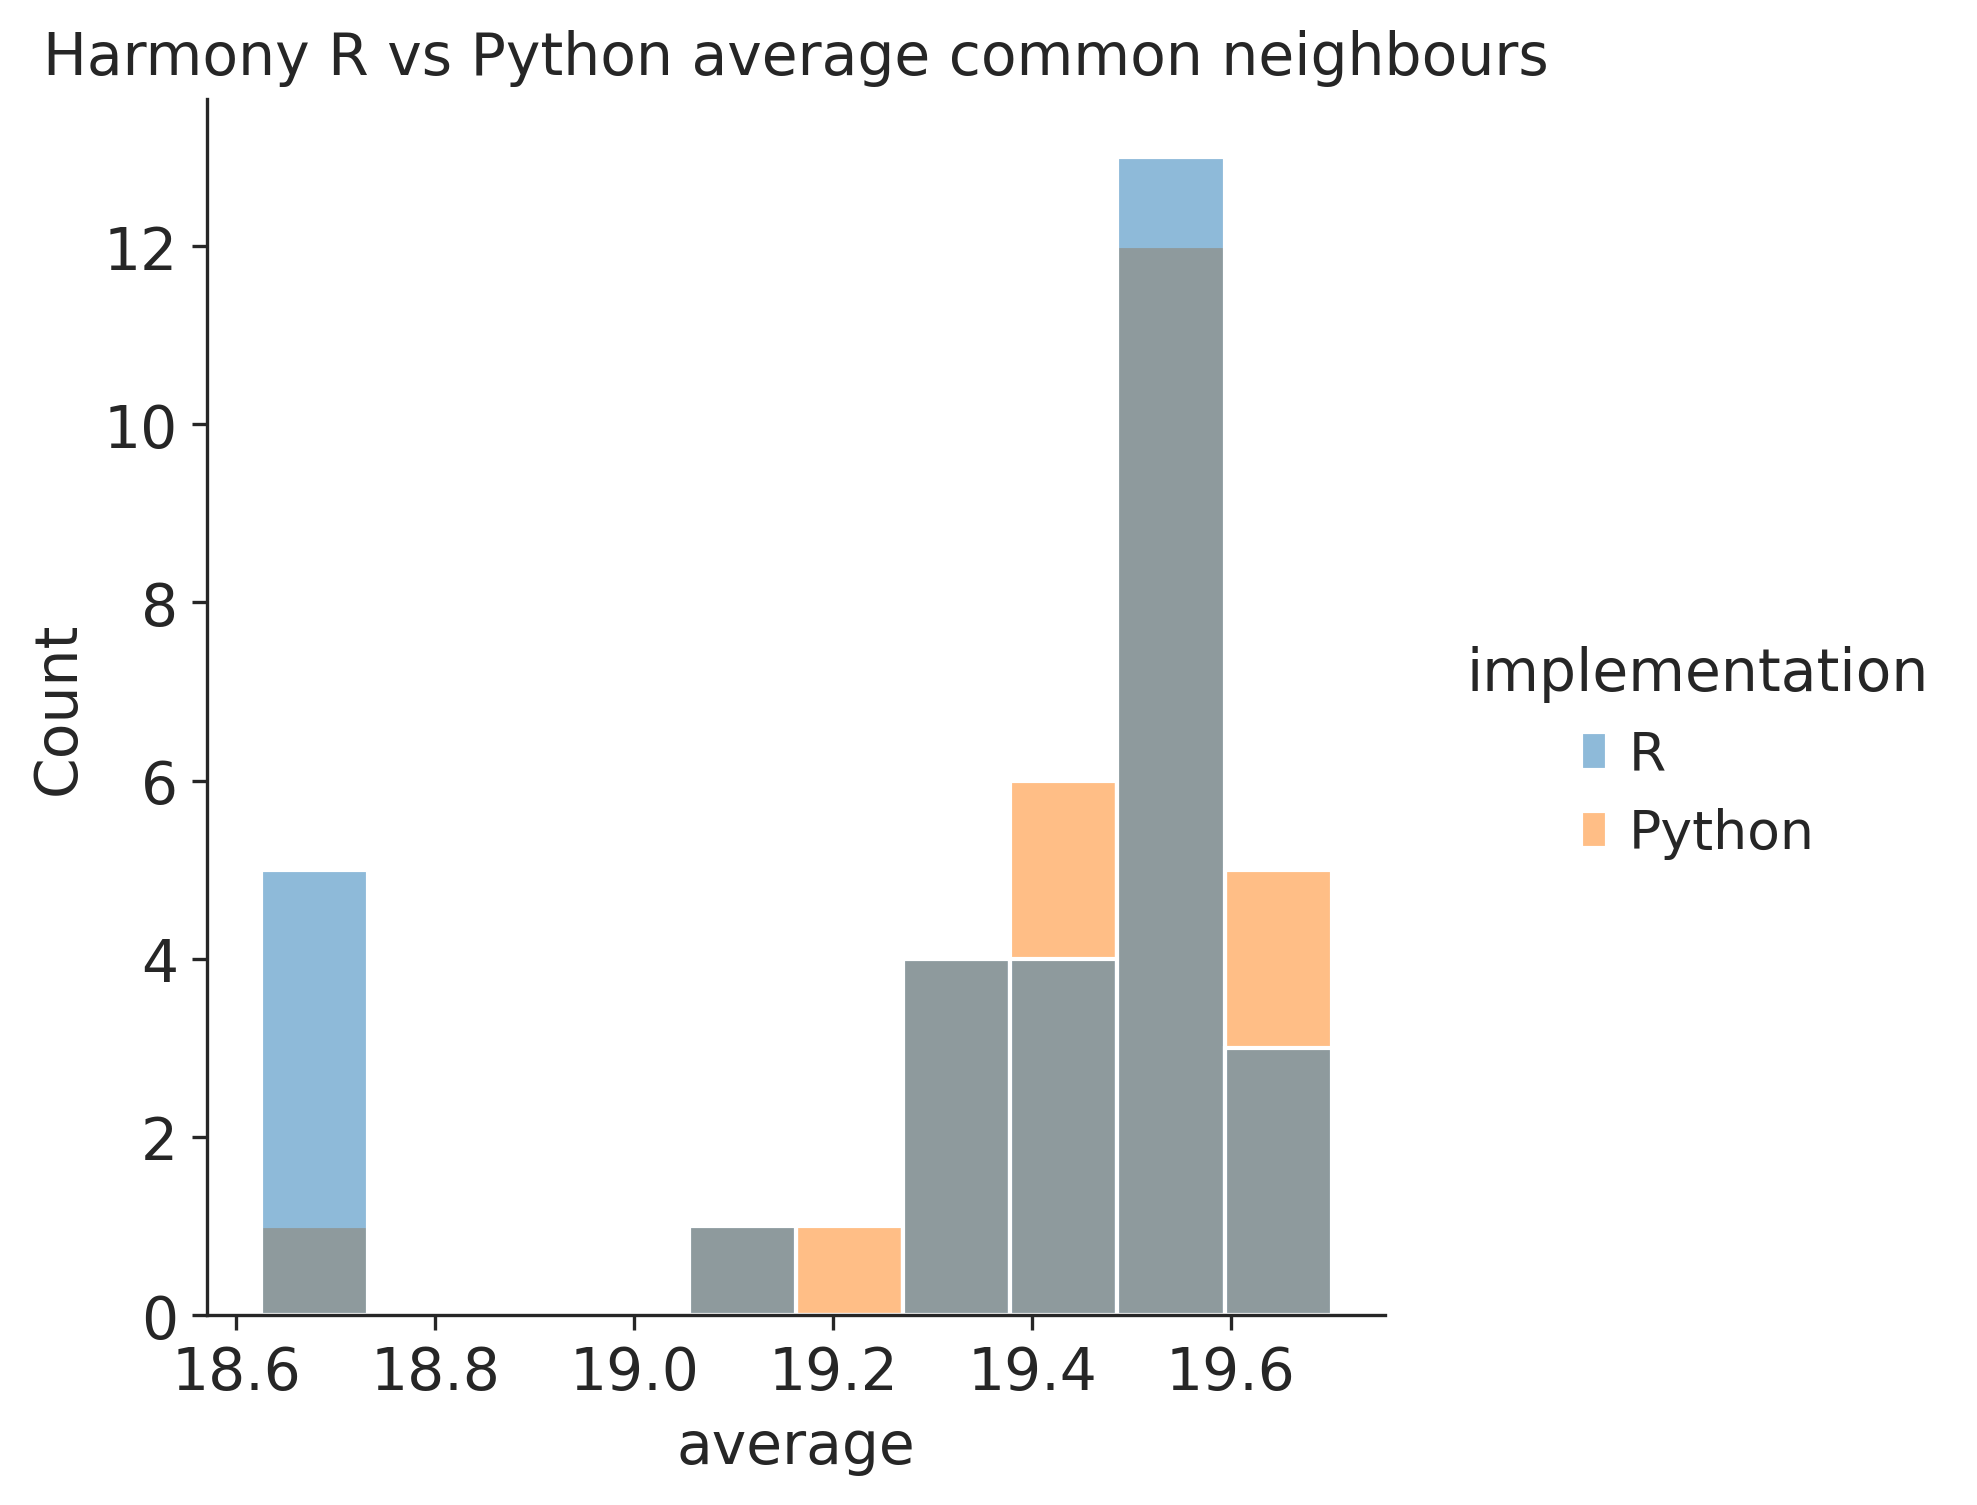

In [40]:
sns.displot(data=average_df, x="average", hue="implementation").set(title="Harmony R vs Python average common neighbours")